15.5


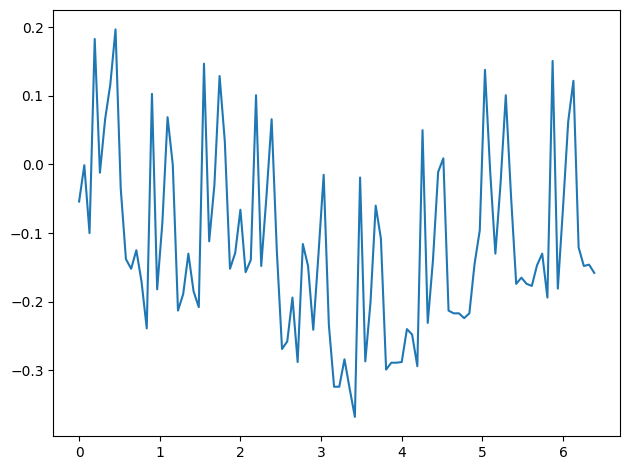

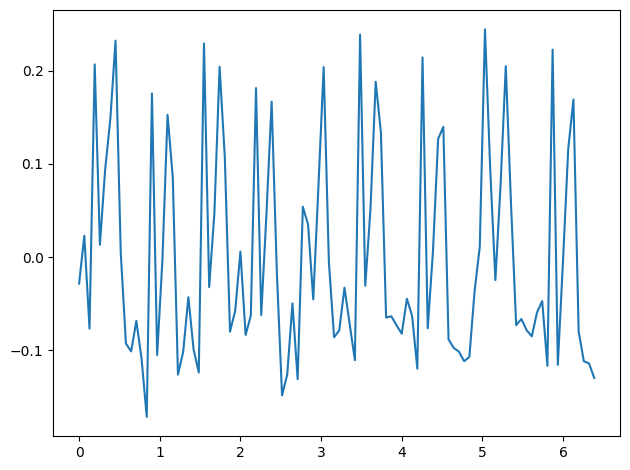

([7, 24, 54, 78, 91, 95], [0.45161290322580644, 1.5483870967741935, 3.4838709677419355, 5.032258064516129, 5.870967741935484, 6.129032258064516])


In [7]:
import wfdb
from wfdb import processing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.fft import fft, ifft
import math


def load_data(path):
    """Loads database file and returns ECG signal samples and fields list"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ECG = signals[:,0]
        return ECG, fields
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None


def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Removes the baseline wander for better manipulation with data. Using Fourier Transformation
    to locate lowfrequency components and erasing them."""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1/sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline

def plot(data, samp_rate):
    """Creates a plot. F(t)"""
    time = np.arange(0, len(data) / samp_rate, 1 / samp_rate)

    plt.plot(time, data)
    plt.tight_layout()
    plt.show()



def find_Rpeaks_dynamic_window_simple(ecg_flatten_signal, samp_rate, max_window_size=30):
    """Finds R peaks in ECG signal with dynamically changing window size.
    Returns a list of peaks and corresponding times."""
    margin = int(samp_rate/5)
    r_peaks = []
    time = []
    current_position = 0
    signal_avg = np.mean(ecg_flatten_signal)

    while current_position < len(ecg_flatten_signal):
        # Set the window size for analysis
        window_size = min(max_window_size, len(ecg_flatten_signal) - current_position - 1)

        # Extract the window signal
        window_signal = ecg_flatten_signal[current_position: current_position + window_size]

        # Check if the window is empty
        if not window_signal.any():
            current_position += margin
            continue

        # Find the position with the maximum value in the window
        max_value = window_signal[0]
        max_position_in_window = 0

#        for i, value in enumerate(window_signal):
#            if value > max_value:
#                max_value = value
#                max_position_in_window = i

        max_position_in_window = np.argmax(window_signal)

        # Check if the value at the maximum position is greater than the signal average
        max_position_in_signal = current_position + max_position_in_window
        if ecg_flatten_signal[max_position_in_signal] > signal_avg:
            r_peaks.append(max_position_in_signal)
            time.append(max_position_in_signal / samp_rate)

        # Move by margin samples from the maximum position for the next window
        current_position = max_position_in_signal + margin

    return r_peaks, time


database = 'Database/drive05'
ECGnative, fields = load_data(database)
samp_rate = fields['fs']
print(samp_rate)

#crapped data for rewiev
ecg_data = np.array(ECGnative[:100])
plot(ecg_data, samp_rate)

cutoff_frequency = 0.5

ecg_edit_fft = remove_baseline_wander_fft(ecg_data, samp_rate, cutoff_frequency=cutoff_frequency)

Rpeaks = find_Rpeaks_dynamic_window_simple(ecg_edit_fft, samp_rate)
plot(ecg_edit_fft, samp_rate)
print(Rpeaks)